In [2]:
from __future__ import division
import os
import urllib, cStringIO
import pymongo as pm ## first establish ssh tunnel to server where database is running
import base64
import numpy as np
from numpy import *
import PIL
from PIL import Image
import base64
import matplotlib
%matplotlib inline
from matplotlib import pylab, mlab, pyplot
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches

import pandas as pd
from svgpathtools import parse_path

#### directory and file hierarchy

In [3]:
# directory & file hierarchy
exp_path = 'museumdraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    

import sys
## add helpers to python path
if os.path.abspath(os.getcwd()) not in sys.path:
    sys.path.append(os.path.abspath(os.getcwd()))
    
import svg_distance_helpers as rsh
reload(rsh)

<module 'svg_distance_helpers' from 'svg_distance_helpers.pyc'>

In [4]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']

#### fetch an example tracing

In [5]:
imrecs = coll.find({'$and':[{'category':'this circle'},{'dataType':'finalImage'},{'sessionId': 'cdm_run_v31525893174061'}]}).sort('time')
imrec = imrecs[0]

In [6]:
## get list of vertices and codes for tracing 
try:
    ## get the corresponding stroke records for this tracing
    stroke_recs = coll.find({'$and': [{'sessionId':imrec['sessionId']}, 
                                      {'dataType':'stroke'},
                                      {'trialNum': imrec['trialNum']}]}).sort('time')

    print 'Number of strokes in this tracing: {}'.format(stroke_recs.count())    
    print stroke_recs[0]
    
    ## check to make sure that there is at least one stroke! 
    if stroke_recs.count()>0:

        ## now make an svg list!
        svg_list = rsh.make_svg_list(stroke_recs)

        ## now get me some verts and codes!
        __Verts, __Codes = rsh.get_verts_and_codes(svg_list)
        
except Exception as e:
    print 'Oops, something went wrong! Here is the error:'  
    print e
    pass        

Number of strokes in this tracing: 1


#### preprocessing of tracing and visualization (if desired)

In [37]:
## simplify tracing if it is a jungle of verts/horiz commands
reallySimplify = 1
if reallySimplify:
    _Verts,_Codes = rsh.simplify_verts_and_codes(__Verts,__Codes)
else:
    if len(__Verts) == 1:
        _Verts = np.array(__Verts[0])
        _Codes = __Codes[0]
        
    else:
        _Verts, _Codes = rsh.multistroke_to_one(__Verts, __Codes)

In [8]:
## make sure the last vertex of the tracing 
## is equal to the first vertex so the
## polygon centroid formula works
if np.sum(_Verts[0][-1] - _Verts[0][0]) != 0:
    _Verts = np.vstack((_Verts,_Verts[0]))
    _Codes.append(2)
assert len(_Verts)==len(_Codes)

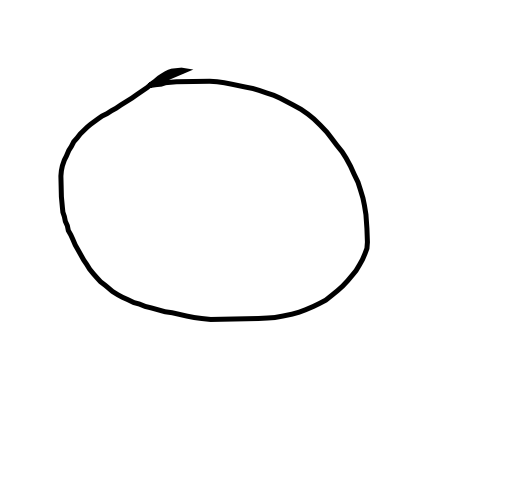

In [9]:
## examine tracing
reallyRun = 1
if reallyRun:
    rsh.plot_shape(_Verts,_Codes)

In [10]:
## get vertices and codes for reference shape (in this example, a square)
Verts, Codes = rsh.get_ref_circle(_Verts,_Codes)

delta (308.6219126102067, 15.28119945612635)
new point (708, 415)
delta (307.48857568402644, 30.52500325649039)
new point (707, 430)
delta (305.6027626868324, 45.694107258765904)
new point (705, 445)
delta (302.9690885190372, 60.75139012355015)
new point (702, 460)
delta (299.5939982226582, 75.66000415650187)
new point (699, 475)
delta (295.4857512092194, 90.38346548082396)
new point (695, 490)
delta (290.6544010475878, 104.88574331942363)
new point (690, 504)
delta (285.1117708612053, 119.13134816826168)
new point (685, 519)
delta (278.8714243949247, 133.085418645116)
new point (678, 533)
delta (271.9486328222532, 146.71380680122547)
new point (671, 546)
delta (264.36033737423145, 159.98316168704298)
new point (664, 559)
delta (256.1251078814026, 172.8610109675975)
new point (656, 572)
delta (247.26309733032528, 185.31584038773937)
new point (647, 585)
delta (237.7959925458381, 197.31717089280323)
new point (637, 597)
delta (227.74696111976542, 208.83563321596256)
new point (627, 608)

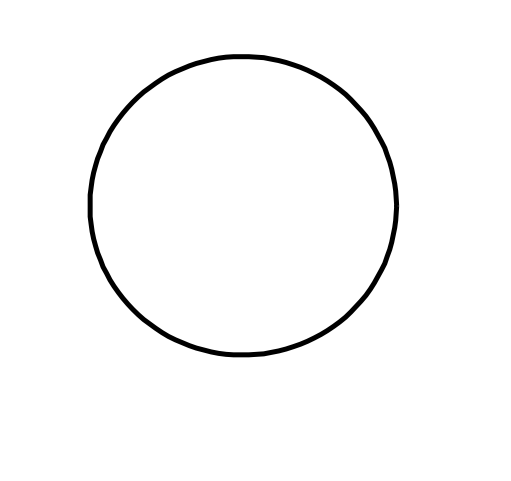

In [11]:
## examine reference shape (in this example, a square)
reallyRun = 1
if reallyRun:
    rsh.plot_shape(Verts,Codes)

In [12]:
## get centroid of both shapes
ref_cx,ref_cy = rsh.get_centroid_polygon(Verts)
tra_cx,tra_cy = rsh.get_centroid_polygon(_Verts)

ref_centroid = np.array((ref_cx,ref_cy))
tra_centroid = np.array((tra_cx,tra_cy))

In [13]:
## get verts and codes for the reference and tracing
ref_verts = Verts-ref_centroid
ref_codes = Codes
tra_verts = _Verts-tra_centroid
tra_codes = _Codes

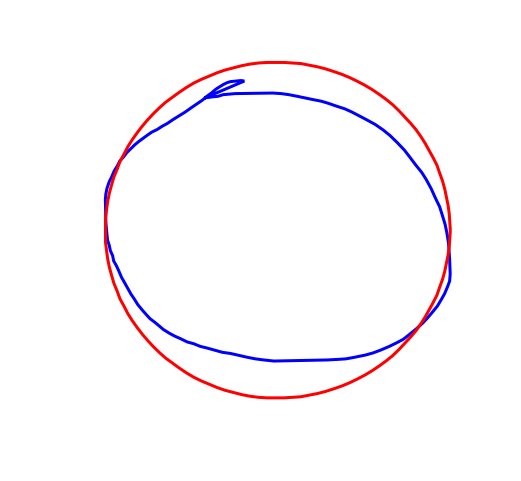

In [14]:
reallyRun = 1
if reallyRun:
    rsh.plot_coregistered_shapes(ref_verts,ref_codes,tra_verts,tra_codes)

##### test case for particular line segment AB on reference shape and point P on tracing (optional, sanity checks)

In [15]:
run_tests = 0
if run_tests:
    ## toy case
    A = np.array((0,0))
    B = np.array((10,10))
    P = np.array((20,5)) ## first point

    ## get point C on A,B that minimizes distance from particular point on tracing to the line segment AB
    C = rsh.get_closest_point_from_P_to_AB(A,B,P,verbose=False) 
    
    ## example real case
    a = ref_verts[0]
    b = ref_verts[1]
    p = tra_verts[1]
    c,d = rsh.get_closest_point_from_P_to_AB(a,b,p,verbose=False) 
    print c,d    

#### get "corresponding points" on the reference shape for each vertex in the tracing

In [16]:
## for each tra_verts, find the closes vertex on the reference shape and add it to the cor_verts
cor_verts = np.zeros((np.shape(tra_verts)[0],2))
for i,t in enumerate(tra_verts): ## loop through segments of the tracing
    D = 1e6 ## initialize at some crazy large value
    C = (0,0)
    for r in ref_verts:
        d = rsh.get_distance_two_points(t,r) 
        if d<D: ## if the shortest distance so far, then swap in for the value of D
            D = d
            C = r
        else:
            pass 
    cor_verts[i,:] = C ## assign the closest corresponding point to the "corresponding vertices" array

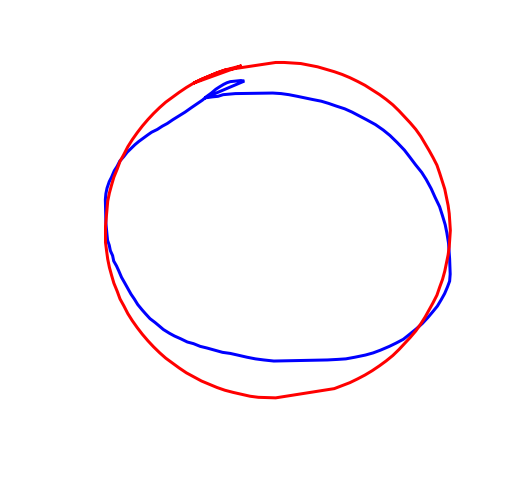

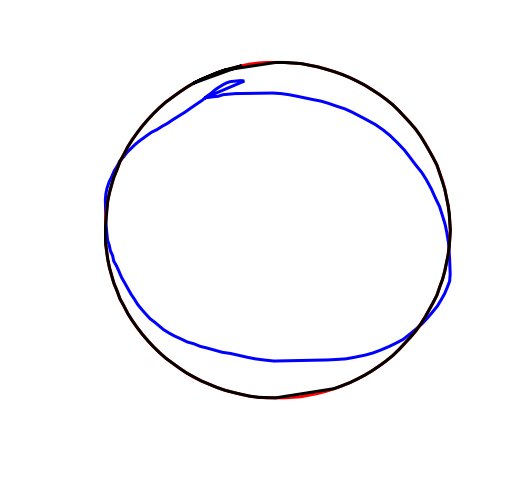

In [18]:
## show the corresponding shape and the tracing shape
reload(rsh)
reallyRun = 1
if reallyRun:
    # draw the corresponding shape and tracing
    rsh.plot_coregistered_shapes(cor_verts,ref_codes,tra_verts,tra_codes)
    # draw corresponding, tracing and reference
    rsh.plot_corresponding_points_on_reference(tra_verts,tra_codes,ref_verts,ref_codes,cor_verts)

#### actually get svg distance error now

In [35]:
reload(rsh)
## iterate through each pair of line segments comprising the tracing verts
## and corresponding verts, and increment error as area between the line
## segments. 
## When line segments are non-intersecting and non-collinear, safe to use
## general polygon area formula (add the trapezoid)
## If line segments are parallel but not collinear, safe to use
## general polygon area formula (add the trapezoid)
## If line segments intersect, then add the resulting triangles
## formed by the intersecting segments
## If line segments are collinear, do not increment error, b/c perfectly on the line
tracing_to_corresponding_error = rsh.get_area_between_tracing_and_corresponding_verts(tra_verts,cor_verts)

## add to the above the deviation between the area of the reference
## shape and the corresponding shape
cor_area = rsh.get_area_polygon(cor_verts)
ref_area = rsh.get_area_polygon(ref_verts)
corresponding_to_reference_error = abs(abs(ref_area)-abs(cor_area))

In [36]:
## total error is sum of tracing_to_corresponding_error and corresponding_to_reference_error
total_error = tracing_to_corresponding_error - corresponding_to_reference_error

svg_distance_score = np.sqrt(total_error)
print 'SVG distance score = {}'.format(svg_distance_score)

SVG distance score = 464.090962608
